## **Extracting Data from DBPedia**

1. Install and import libraries that will be used to prepare boh hypotheses

In [24]:
!pip install SPARQLWrapper
!pip install scipy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from SPARQLWrapper import SPARQLWrapper, JSON, N3
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import regex as re

2. Define SPARQL query which extracts wanted data from DBPedia.


In [26]:
# location where the csv will be outputted
csv_location = os.getcwd() + "/output.csv"

# we can add more variables to fetch from DBpedia here

sparql_query = {
    "SELECT": ["?city_name", "?latitude", "?longitude", "?total_pop"],
    "UNION": [
        # {
        #     '?city  rdf:type  yago:WikicatCityCountiesOfPoland': ' ',
        #     'dbo:country  dbr:Poland': ' ',
        #     'foaf:name': '?city_name',
        #     'geo:lat': '?latitude',
        #     'geo:long': '?longitude',
        #     'dbp:populationTotal': '?total_pop',
        # },
        {
            '?city  rdf:type  dbo:City': ' ',
            'dbo:country  dbr:Netherlands': ' ',
            'foaf:name': '?city_name',
            'geo:lat': '?latitude',
            'geo:long': '?longitude',
            'dbp:populationTotal': '?total_pop',
        },
        {
            '?city  rdf:type  dbo:Town': ' ',
            'dbo:country  dbr:Netherlands': ' ',
            'foaf:name': '?city_name',
            'geo:lat': '?latitude',
            'geo:long': '?longitude',
            'dbp:populationTotal': '?total_pop',
        },
        {
            '?city  rdf:type  dbo:Village': ' ',
            'dbo:country  dbr:Netherlands': ' ',
            'foaf:name': '?city_name',
            'geo:lat': '?latitude',
            'geo:long': '?longitude',
            'dbp:populationTotal': '?total_pop',
        }
    ],
}

3. Create a function to format and execute the query based on the variables given before

In [27]:
def query_data(query_data: dict):

    def format_query(_query_data: dict):
        # create SELECT statement
        _result = '''SELECT DISTINCT'''
        for variable in _query_data["SELECT"]:
            _result += variable + " "
        _result += '\n'

        # create WHERE statement
        _result += "WHERE {\n"
        for union_item in _query_data["UNION"]:

            # process each UNION statement
            _result += "{\n"
            for key, value in union_item.items():
                _result += key + " " + value + " ;\n"
            _result = _result[:-2] + ".\n } UNION "

        _result = _result[:-7] + "}\n"

        # create ORDER BY statement
        _result += '''ORDER BY DESC(?total_pop) '''   # ugly hack

        # create LIMIT statement (used for testing)
        #_result += ''' LIMIT 10 '''

        return _result

    # initialize the wrapper
    sparql = SPARQLWrapper('https://dbpedia.org/sparql')

    # construct and fire the query
    query = format_query(query_data)

    sparql.setQuery(query)

    # parse the result
    sparql.setReturnFormat(JSON)
    qres = sparql.query().convert()

    # digest it
    digested = []
    for result in qres['results']['bindings']:

        entry = {}
        for value in query_data["SELECT"]:
            if value[0] == '?':
                entry[value[1:]] = result[value[1:]]    # extract relevant fields
        digested.append(entry)

    return digested

4. Create a function to save the output query data to csv file

In [28]:
def output_to_csv(data: list, file_path: str):

    # open file and prepare csv writer
    with open(file_path, 'w', encoding='UTF8') as file:
        writer = csv.writer(file)

        # output headers
        headers = []
        for key in data[0]:
            headers.append(str(key))
        writer.writerow(headers)

        # output data
        for entry in data:
            row = []
            for key, value in entry.items():
                row.append(value["value"])
            writer.writerow(row)

5. Running the function to query the data and save the file to csv

In [29]:
# fetch digested data
data = query_data(sparql_query)

# save to csv
output_to_csv(data, csv_location)
print(data)

[{'city_name': {'type': 'literal', 'xml:lang': 'en', 'value': 'Amsterdam'}, 'latitude': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#float', 'value': '52.3667'}, 'longitude': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#float', 'value': '4.9'}, 'total_pop': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'value': '872680'}}, {'city_name': {'type': 'literal', 'xml:lang': 'en', 'value': 'Rotterdam'}, 'latitude': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#float', 'value': '51.9167'}, 'longitude': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#float', 'value': '4.5'}, 'total_pop': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'value': '651157'}}, {'city_name': {'type': 'literal', 'xml:lang': 'en', 'value': 'The Hague'}, 'latitude': {'type': 'typed-literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#float', 'val

6. Preview the csv table that has been created6. Preview the csv table that has been created

In [53]:
df_dirty = pd.read_csv('/content/output.csv')
df_dirty.head()

,city_name,latitude,longitude,total_pop
0,Amsterdam,52.3667,4.90000,872680
1,Rotterdam,51.9167,4.50000,651157
2,The Hague,52.0800,4.31000,549163
3,Utrecht,52.0833,5.11667,359370
4,Groningen,53.2167,6.56667,233218


In [54]:
df_dirty.tail()

,city_name,latitude,longitude,total_pop
1190,Paesens-Moddergat,53.4019,6.08250,c. 450
1191,Oosterzee-Buren,52.8683,5.74806,c. 350
1192,Marijenkampen,52.8167,6.05000,c. 250
1193,Oldehove,53.3000,6.40000,c. 1.648
1194,Almenum,53.1833,5.43333,c. 0


## **Cleaning Data**

1. Remove character from total_pop and convert it to integer

In [55]:
df = df_dirty

In [56]:
for i in range(df['total_pop'].size):
  df['total_pop'][i] = re.sub( '[^0-9]', '', df['total_pop'][i])
  df['total_pop'][i] = int(df['total_pop'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2. Filtering row with any NaN values and zero population cities

In [57]:
print('Row with NaN values=', df['city_name'].isna().sum())
df[df['city_name'].isnull()]

Row with NaN values= 3


,city_name,latitude,longitude,total_pop
96,NaN,52.2700,4.97000,8657
103,NaN,52.2167,5.01667,8222
119,NaN,50.7778,5.70833,7000


In [58]:
df = df.replace(0, np.nan)
df = df.dropna(how='any',axis=0) 
df.head()

,city_name,latitude,longitude,total_pop
0,Amsterdam,52.3667,4.90000,872680.0
1,Rotterdam,51.9167,4.50000,651157.0
2,The Hague,52.0800,4.31000,549163.0
3,Utrecht,52.0833,5.11667,359370.0
4,Groningen,53.2167,6.56667,233218.0


In [59]:
df.tail()

,city_name,latitude,longitude,total_pop
1189,Kleaster Anjum,53.2310,5.61400,50.0
1190,Paesens-Moddergat,53.4019,6.08250,450.0
1191,Oosterzee-Buren,52.8683,5.74806,350.0
1192,Marijenkampen,52.8167,6.05000,250.0
1193,Oldehove,53.3000,6.40000,1648.0


2. Reset index after dropping row

In [60]:
df = df.reset_index(drop=True)

In [61]:
df.tail()

,city_name,latitude,longitude,total_pop
1186,Kleaster Anjum,53.2310,5.61400,50.0
1187,Paesens-Moddergat,53.4019,6.08250,450.0
1188,Oosterzee-Buren,52.8683,5.74806,350.0
1189,Marijenkampen,52.8167,6.05000,250.0
1190,Oldehove,53.3000,6.40000,1648.0


# **Testing ZipfLaw**

1. Install and import library that will be used

In [62]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

2. Sort data by cities population and adds 'rank' column based on cities population

In [63]:
sorted_df = df.sort_values(by=["total_pop"], ascending=False)
sorted_df['rank'] = range(1, len(sorted_df) + 1)

In [64]:
sorted_df.head()

,city_name,latitude,longitude,total_pop,rank
0,Amsterdam,52.3667,4.90000,872680.0,1
1,Rotterdam,51.9167,4.50000,651157.0,2
2,The Hague,52.0800,4.31000,549163.0,3
3,Utrecht,52.0833,5.11667,359370.0,4
4,Groningen,53.2167,6.56667,233218.0,5


In [65]:
max_rank = sorted_df['rank'].max()
lowest_pop = sorted_df.loc[sorted_df['rank'] == max_rank, 'total_pop'].iloc[0]
print('Max rank is', max_rank, ' with total population of ', lowest_pop)
sorted_df.tail()

Max rank is 1191  with total population of  5.0


,city_name,latitude,longitude,total_pop,rank
1167,Tjalhuizum,53.0456,5.61194,25.0,1187
1168,Joossesweg,51.5156,3.45611,20.0,1188
1169,Smallebrugge,52.9581,5.63694,20.0,1189
1170,Teerns,53.1833,5.83333,17.0,1190
1175,Breezanddijk,53.0200,5.20694,5.0,1191


3. Add 'zipf_tot_pop' column as a total population data that follow Zipf's Law 

In [66]:
sorted_df.dtypes

city_name     object
latitude     float64
longitude    float64
total_pop    float64
rank           int64
dtype: object

In [67]:
max_pop = sorted_df['total_pop'].max()
sorted_df['zipf_tot_pop'] = max_pop // sorted_df['rank']
sorted_df = sorted_df[['city_name', 'latitude', 'longitude', 'rank', 'total_pop', 'zipf_tot_pop']]
sorted_df.head(20)

,city_name,latitude,longitude,rank,total_pop,zipf_tot_pop
0,Amsterdam,52.3667,4.90000,1,872680.0,872680.0
1,Rotterdam,51.9167,4.50000,2,651157.0,436340.0
2,The Hague,52.0800,4.31000,3,549163.0,290893.0
3,Utrecht,52.0833,5.11667,4,359370.0,218170.0
4,Groningen,53.2167,6.56667,5,233218.0,174536.0
5,Alkmaar,52.6333,4.75000,6,109896.0,145446.0
6,Hilversum,52.2333,5.16667,7,90261.0,124668.0
7,Dijk en Waard,52.6667,4.83333,8,87000.0,109085.0
1098,Meierijstad,51.5833,5.48333,9,79633.0,96964.0
8,Zaandam,52.4333,4.83333,10,76804.0,87268.0


3. Create plot-graph

In [68]:

fig = px.line(sorted_df, x = 'rank', y = 'total_pop' , 
title='Cities in Netherlands based on their Rank', log_x=True,log_y=True)

fig.update_traces(name='Netherlands\'s Cities', showlegend = True)
fig.add_scatter(x = sorted_df['rank'], y = sorted_df['zipf_tot_pop'], name='ZipfLaw')


fig.show()

4. Calculating RMSE and R (correlation coefficient) of plotted graph

In [69]:
import numpy as np 
import sklearn.metrics as metrics

In [70]:
rms = metrics.mean_squared_error(sorted_df['total_pop'], sorted_df['zipf_tot_pop'], squared=False)
print('Root mean square of the graph is', rms)

Root mean square of the graph is 10864.079481863393


In [71]:
r2 = metrics.r2_score(sorted_df['total_pop'], sorted_df['zipf_tot_pop'])
print('The correlation coefficient or R2 is', r2)

The correlation coefficient or R2 is 0.9196354008061182


5. Calculating Hellinger Distance and  Kullback-Leiber Divergence //It has to be in frequenct distribution (?)

In [72]:
clasf_df = sorted_df
clasf_df['diff'] = clasf_df['total_pop'] - clasf_df['zipf_tot_pop']
clasf_df['prob_pop'] = clasf_df['total_pop'] / np.sum(clasf_df['total_pop'])
clasf_df['prob_zip'] = clasf_df['zipf_tot_pop'] / np.sum(clasf_df['zipf_tot_pop'])
clasf_df.head(5)

,city_name,latitude,longitude,rank,total_pop,zipf_tot_pop,diff,prob_pop,prob_zip
0,Amsterdam,52.3667,4.90000,1,872680.0,872680.0,0.0,0.132315,0.130557
1,Rotterdam,51.9167,4.50000,2,651157.0,436340.0,214817.0,0.098728,0.065278
2,The Hague,52.0800,4.31000,3,549163.0,290893.0,258270.0,0.083264,0.043519
3,Utrecht,52.0833,5.11667,4,359370.0,218170.0,141200.0,0.054487,0.032639
4,Groningen,53.2167,6.56667,5,233218.0,174536.0,58682.0,0.035360,0.026111


In [73]:
np.sum(clasf_df['prob_zip'])

1.0

In [74]:
clasf_df['norm_freq'] = 1/(clasf_df['rank'] * (np.sum(1/clasf_df['total_pop'])))
clasf_df.head(5)

,city_name,latitude,longitude,rank,total_pop,zipf_tot_pop,diff,prob_pop,prob_zip,norm_freq
0,Amsterdam,52.3667,4.90000,1,872680.0,872680.0,0.0,0.132315,0.130557,0.223028
1,Rotterdam,51.9167,4.50000,2,651157.0,436340.0,214817.0,0.098728,0.065278,0.111514
2,The Hague,52.0800,4.31000,3,549163.0,290893.0,258270.0,0.083264,0.043519,0.074343
3,Utrecht,52.0833,5.11667,4,359370.0,218170.0,141200.0,0.054487,0.032639,0.055757
4,Groningen,53.2167,6.56667,5,233218.0,174536.0,58682.0,0.035360,0.026111,0.044606


In [75]:
def hel_dist(true, pred):
  return np.sqrt(0.5 * np.sum((np.sqrt(true) - np.sqrt(pred)) ** 2))

def kul_lei(true, pred):
  return -(np.sum(true * (np.log10(pred / true))))

In [76]:
print('Helinger Distance (P || Q):', hel_dist(clasf_df['prob_pop'], clasf_df['prob_zip']))
print('Helinger Distance (Q || P):', hel_dist(clasf_df['prob_zip'], clasf_df['prob_pop']))
print('Kullback-Leiber Divergence (P || Q) :', kul_lei(clasf_df['prob_pop'], clasf_df['prob_zip']))
print('Kullback-Leiber Divergence (Q || P) :', kul_lei(clasf_df['prob_zip'], clasf_df['prob_pop']))

Helinger Distance (P || Q): 0.141187123717755
Helinger Distance (Q || P): 0.141187123717755
Kullback-Leiber Divergence (P || Q) : 0.03128148184342294
Kullback-Leiber Divergence (Q || P) : 0.040955026424326496


In [77]:
print('Helinger Distance :', hel_dist(clasf_df['prob_zip'], clasf_df['prob_pop']))
print('Kullback-Leiber Divergence :', kul_lei(clasf_df['prob_zip'], clasf_df['prob_pop']))

Helinger Distance : 0.141187123717755
Kullback-Leiber Divergence : 0.040955026424326496


In [88]:
data_std = sorted_df['total_pop'].std()
data_mean = sorted_df['total_pop'].mean()

zipf_std = sorted_df['zipf_tot_pop'].std()
zipf_mean = sorted_df['zipf_tot_pop'].mean()

print("Data mean: {}, Data std: {}".format(data_mean,data_std))
print("Zipf mean: {}, Zipf std: {}".format(zipf_mean,zipf_std))


Data mean: 5537.752308984047, Data std: 38339.19084367641
Zipf mean: 5612.334172963896, Zipf std: 31947.630396195767


# **Classify Cities**

1. Classifying cities by total population based on BDSPR

In [78]:
bbsr_conditions = [
    (clasf_df['total_pop'] < 5000),
    (clasf_df['total_pop'] >= 5000) & (clasf_df['total_pop'] < 10000),
    (clasf_df['total_pop'] >= 10000) & (clasf_df['total_pop'] < 20000),
    (clasf_df['total_pop'] >= 20000) & (clasf_df['total_pop'] < 50000),
    (clasf_df['total_pop'] >= 50000) & (clasf_df['total_pop'] < 100000),
    (clasf_df['total_pop'] >= 100000)
    ]

bbsr_values = ['Rural community', 'Small town', 'Large-small town', 'Small-Medium town',
               'Large-Medium town', 'Large cities']

clasf_df['bbsr_class'] = np.select(bbsr_conditions, bbsr_values)
clasf_df.head(5)


,city_name,latitude,longitude,rank,total_pop,zipf_tot_pop,diff,prob_pop,prob_zip,norm_freq,bbsr_class
0,Amsterdam,52.3667,4.90000,1,872680.0,872680.0,0.0,0.132315,0.130557,0.223028,Large cities
1,Rotterdam,51.9167,4.50000,2,651157.0,436340.0,214817.0,0.098728,0.065278,0.111514,Large cities
2,The Hague,52.0800,4.31000,3,549163.0,290893.0,258270.0,0.083264,0.043519,0.074343,Large cities
3,Utrecht,52.0833,5.11667,4,359370.0,218170.0,141200.0,0.054487,0.032639,0.055757,Large cities
4,Groningen,53.2167,6.56667,5,233218.0,174536.0,58682.0,0.035360,0.026111,0.044606,Large cities


In [80]:
clasf_df['bbsr_class'].value_counts()

Rural community      1031
Small town             69
Large-small town       46
Small-Medium town      27
Large-Medium town      12
Large cities            6
Name: bbsr_class, dtype: int64

2. Visualize Result

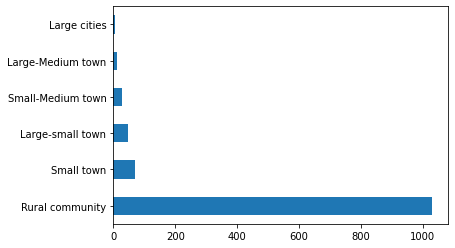

In [81]:
clasf_df['bbsr_class'].value_counts().plot(kind='barh')

In [82]:
df_LC = clasf_df[clasf_df.bbsr_class == 'Large cities']
df_LST = clasf_df[clasf_df.bbsr_class == 'Large-small town']
df_SMT = clasf_df[clasf_df.bbsr_class == 'Small-Medium town']
df_LMT = clasf_df[clasf_df.bbsr_class == 'Large-Medium town']
df_ST = clasf_df[clasf_df.bbsr_class == 'Small town']
df_RC = clasf_df[clasf_df.bbsr_class == 'Rural community']


In [83]:
fig = go.Figure(go.Bar(x = df_LC['diff'], y = df_LC['city_name'], orientation='h'))
fig.update_layout(title='Difference population of large cities in Poland to Zipf scenario')
fig.show()

In [84]:
fig = go.Figure(go.Bar(x = df_LMT['diff'], y = df_LMT['city_name'], orientation='h'))
fig.update_layout(title='Difference population of large medium town in Poland to Zipf scenario')
fig.show()

In [85]:
fig = go.Figure(go.Bar(x = df_SMT['diff'], y = df_SMT['city_name'], orientation='h'))
fig.update_layout(title='Difference population of small medium town in Poland to Zipf scenario')
fig.show()

In [87]:
fig = go.Figure(go.Bar(x = df_LST['diff'], y = df_LST['city_name'], orientation='h'))
fig.update_layout(title='Difference population of large small town in Poland to Zipf scenario')
fig.show()

In [86]:
fig = go.Figure(go.Bar(x = df_ST['diff'], y = df_ST['city_name'], orientation='h'))
fig.update_layout(title='Difference population of small town in Poland to Zipf scenario')
fig.show()